In [27]:
# Parameters
artificial_humans = {
    # "human managed": {
    #     "contribution_model": "artifacts/behavioral_cloning/17_contribution_model_short_v3/model/architecture_node+edge+rnn__dataset_human_manager.pt",
    #     "valid_model": "artifacts/behavioral_cloning/19_contribution_valid_model_v2/model/rnn_False__dataset_human_manager.pt",
    # },
    "full": {
        "contribution_model": "artifacts/behavioral_cloning/17_contribution_model_short_v3/model/architecture_node+edge+rnn__dataset_full.pt",
        "valid_model": "artifacts/behavioral_cloning/19_contribution_valid_model_v2/model/rnn_False__dataset_full.pt",
    },
}
managers = {
    "humanlike": {
        "type": "human",
        "path": "artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt",
        "autoregressive": True,
    },
    "optimal": {
        "type": "rl",
        "path": "artifacts/manager/04_model/model/architecture_node+edge+rnn__run_0.pt",
    },
}
n_episode_steps = 32
n_episodes = 100
output_dir = "../../notebooks/test_manager/simulate_mixed/02_all_artifacts"
basedir = "../.."


In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import torch as th
import numpy as np
import seaborn as sns
import pandas as pd
import random
from itertools import count
from aimanager.utils.utils import make_dir

from aimanager.manager.memory import Memory
from aimanager.manager.environment import ArtificialHumanEnv

from aimanager.manager.api_manager import MultiManager
from aimanager.artificial_humans import GraphNetwork
from aimanager.utils.array_to_df import using_multiindex, add_labels

plot_folder = output_dir

make_dir(plot_folder)

managers = {k:{**v, 'model_path': os.path.join(basedir, v['path'])} for k,v in managers.items()}
managers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'humanlike': {'type': 'human',
  'path': 'artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt',
  'autoregressive': True,
  'model_path': '../../artifacts/behavioral_cloning/18_punishment_autoregressive_v2/model/architecture_node+edge.pt'},
 'optimal': {'type': 'rl',
  'path': 'artifacts/manager/04_model/model/architecture_node+edge+rnn__run_0.pt',
  'model_path': '../../artifacts/manager/04_model/model/architecture_node+edge+rnn__run_0.pt'}}

In [29]:
def mem_to_df(recorder, name):
    columns = ['episode','participant_code','round_number']

    punishments = using_multiindex(recorder.memory['punishment'].squeeze(1).numpy(), columns=columns, value_name='punishment')
    common_good = using_multiindex(recorder.memory['common_good'].squeeze(1).numpy(), columns=columns, value_name='common_good')
    contributions = using_multiindex(recorder.memory['contribution'].squeeze(1).numpy(), columns=columns, value_name='contribution')
    group = using_multiindex(recorder.memory['group'].squeeze(1).numpy(), columns=columns, value_name='group')

    df_sim = punishments.merge(common_good).merge(contributions).merge(group)

    df_sim['participant_code'] = df_sim['participant_code'].astype(str) + '_' + df_sim['episode'].astype(str)

    df_sim['run'] = name
    return df_sim

def make_round(contributions, round, groups, episode_group_idx):
    return {
        'contribution': contributions,
        'contribution_valid': [c is not None for c in contributions],
        'punishment_valid': [False] * len(contributions),
        'punishment': [None] * len(contributions),
        'group': groups,
        'round': round,
        'episode_group_idx': episode_group_idx
    }

def add_punishments(round, punishments):
    return {
        **round,
        'punishment': punishments,
        'punishment_valid': [p is not None for p in punishments],
    }


In [30]:
device = th.device('cpu')
rec_device = th.device('cpu')

mm = MultiManager(
    managers,
    n_steps=n_episode_steps,
)

# fix bug
for k, man  in mm.managers.items():
    if 'autoregressive' in managers[k]:
        man.model.autoregressive = managers[k]['autoregressive']

runs = {
    f"ah {h} managed by {m}": {'groups': [m]*4, 'humans': h}
    for m in managers.keys()
    for h in artificial_humans.keys()
}

dfs = []
for name, run in runs.items():
    print(f'Start run {name}')
    groups = run['groups']
    n_agents = len(groups)

    hm_path = os.path.join(basedir, artificial_humans[run['humans']]['contribution_model'])
    hmv_path = os.path.join(basedir, artificial_humans[run['humans']]['valid_model'])

    ah = GraphNetwork.load(hm_path, device=device)
    ah_val = GraphNetwork.load(hmv_path, device=device)
    env = ArtificialHumanEnv(
        artifical_humans=ah, 
        artifical_humans_valid=ah_val, 
        n_agents=n_agents, n_contributions=21, n_punishments=31, 
        n_rounds=n_episode_steps, batch_size=1, device=device)
    recorder = Memory(
        n_episodes=n_episodes, n_episode_steps=n_episode_steps, output_file=None, device=device)
    for e in range(n_episodes):
        state = env.reset()
        episode_group_idx = random.randint(0,1000000)
        rounds = []
        for round_number in count():
            contributions = state['contribution'].squeeze().tolist()
            round = make_round(contributions, round_number, groups, episode_group_idx)
            punishments = mm.get_punishments(rounds+[round])[0]
            round = add_punishments(round, punishments)
            rounds.append(round)
            punishments = th.tensor(punishments, dtype=th.int64)
            state = env.punish(punishments.unsqueeze(-1).unsqueeze(0))
            recorder.add(
                **{k: v if len(v.shape) == 3 else v.unsqueeze(-1) for k, v in state.items()}, 
                episode_step=round_number)
            state, reward, done = env.step()
            if done:
                break
        recorder.next_episode(e)
    dfs.append(mem_to_df(recorder, name=name))
   

Start run ah full managed by humanlike
Start run ah full managed by optimal


In [31]:
data_file = 'experiments/pilot_random1_player_round_slim.csv'
data_file = os.path.join(basedir, data_file)

df_pilot = pd.read_csv(data_file)

experiment_name_map = {
    'trail_rounds_2': 'pilot human manager',
    'random_1': 'pilot rule based manager'
}

df_pilot['run'] = df_pilot['experiment_name'].map(experiment_name_map)
df_pilot['common_good'] = df_pilot['common_good'] / 4
df_pilot = df_pilot[['round_number', 'common_good', 'contribution', 'participant_code', 'punishment', 'run', 'global_group_id']]

df_pilot['episode'] = df_pilot['global_group_id']

df = pd.concat([*dfs, df_pilot]).reset_index(drop=True)

df['episode'] = df['run'] + '__' + df['episode'].astype(str)

dfm = df.melt(
    id_vars=['episode', 'round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'contribution', 'common_good'])

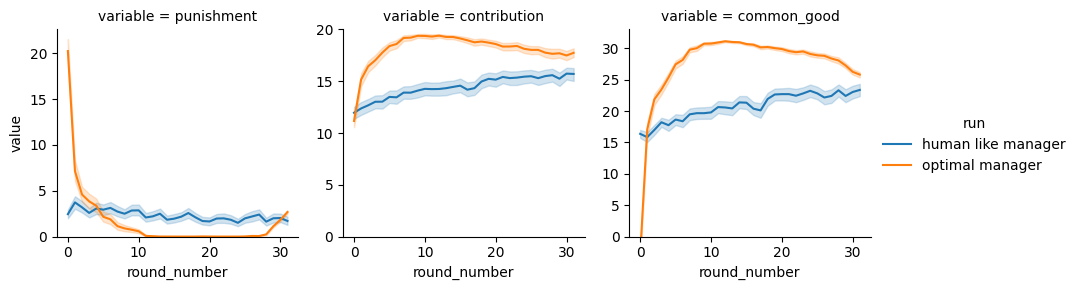

In [32]:
w = dfm['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    # 'pilot human manager',
    # 'pilot rule based manager',
])

dfg = dfm[w].copy()
dfg['run'] = dfg['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
})


g = sns.relplot(
    data=dfg,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)


# Set y-axis limits to start at 0 for all plots
g.set(ylim=(0, None))

g.savefig(os.path.join(plot_folder, 'comparison_manager.jpg'))

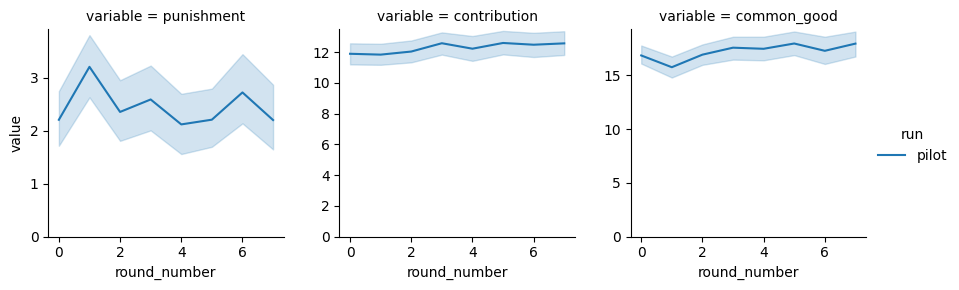

In [33]:
w = dfm['run'].isin([
    'ah human managed managed by optimal',
    'ah human managed managed by humanlike',
    'pilot human manager',
    # 'pilot rule based manager',
])

dfg = dfm[w].copy()
dfg['run'] = dfg['run'].map({
    'ah human managed managed by optimal': 'optimal manager *',
    'ah human managed managed by humanlike': 'human like manager *',
    'pilot human manager': 'pilot',
    'pilot rule based manager': 'pilot rule based manager'
})


g = sns.relplot(
    data=dfg,
    x="round_number", 
    y="value",
    col='variable',
    hue='run',
    kind="line",
    facet_kws={'sharey': False, 'sharex': True},
    height=3, aspect=1,
)

# Set y-axis limits to start at 0 for all plots
g.set(ylim=(0, None))

g.savefig(os.path.join(plot_folder, 'comparison_pilot.jpg'))

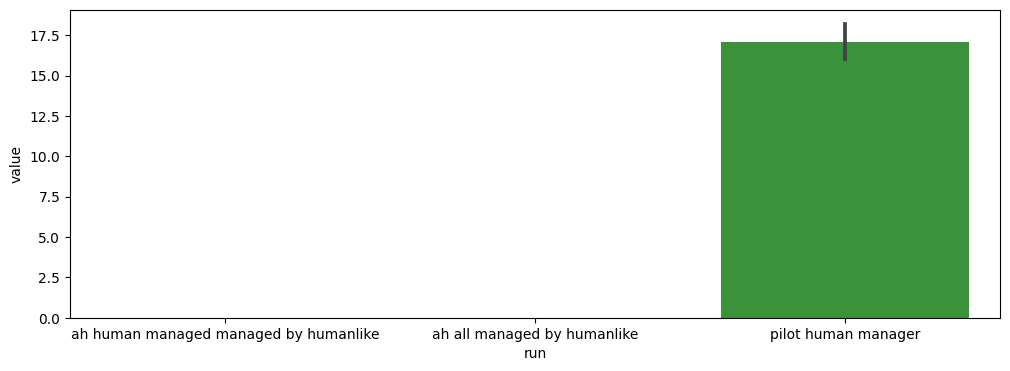

In [34]:
try:
    from statannotations.Annotator import Annotator
    import matplotlib.pyplot as plt

    order = ['ah human managed managed by humanlike', 'ah all managed by humanlike', 'pilot human manager']

    w = (
        (dfm['round_number'] < 8) &
        (dfm['variable'] == 'common_good') &
        (dfm['run'].isin(order))
    )

    dfg = dfm[w].groupby(['participant_code', 'run', 'variable'])["value"].mean().reset_index()

    pairs = [[order[0], order[2]], [order[1], order[2]]]

    plt.figure(figsize=(12,4))

    ax = sns.barplot(
        data=dfg,
        order=order,
        x="run", 
        y="value")

    annotator = Annotator(ax, pairs, data=dfg, x='run', y='value', order=order)
    annotator.configure(test='Mann-Whitney', text_format='simple', loc='inside')
    annotator.apply_and_annotate()

    plt.savefig(os.path.join(plot_folder, 'comparison_pilot_bar.jpg'))
except:
    pass

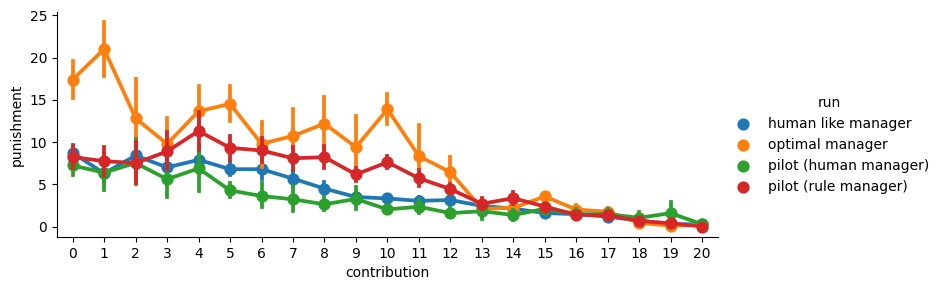

In [35]:
df['contribution'] = df['contribution'].astype(int)


w = df['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    'pilot human manager',
    'pilot rule based manager',
])

dfs = df[w].copy()
dfs['run'] = dfs['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
    'pilot human manager': 'pilot (human manager)',
    'pilot rule based manager': 'pilot (rule manager)'
})


g = sns.catplot(
    data=dfs,
    x="contribution", 
    y="punishment",
    hue='run',
    kind="point",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy.jpg'))

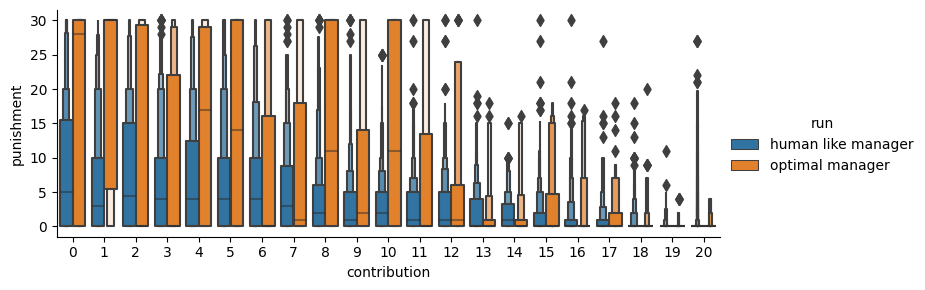

In [36]:
df['contribution'] = df['contribution'].astype(int)

w = df['run'].isin([
    'ah full managed by optimal',
    'ah full managed by humanlike',
    # 'pilot human manager',
    # 'pilot rule based manager',
])

dfs = df[w].copy()
dfs['run'] = dfs['run'].map({
    'ah full managed by optimal': 'optimal manager',
    'ah full managed by humanlike': 'human like manager',
    'pilot human manager': 'pilot (human manager)',
    'pilot rule based manager': 'pilot (rule manager)'
})


g = sns.catplot(
    data=dfs,
    x="contribution", 
    y="punishment",
    hue='run',
    kind="boxen",
    height=3, aspect=2.5,
)

g.savefig(os.path.join(plot_folder, 'comparison_pilot_policy_box.jpg'))

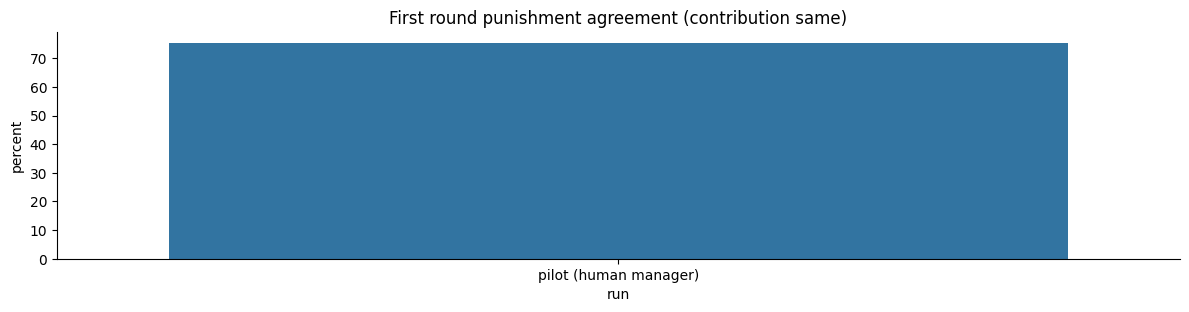

In [37]:
df['contribution'] = df['contribution'].astype(int)

w = (df['run'].isin([
    'ah human managed managed by humanlike',
    'pilot human manager',
]) & (df['round_number'] == 0) & (df['contribution'] != 20))

dfs = df[w].copy()


dfs['run'] = dfs['run'].map({
    'ah human managed managed by humanlike': 'human like manager',
    'pilot human manager': 'pilot (human manager)',
})

merge_on = ['run','episode', 'round_number']
keep = ['punishment', 'contribution', 'participant_code']

dfm = pd.merge(left=dfs[merge_on+keep], right=dfs[merge_on+keep], on=merge_on)
dfm = dfm[dfm['participant_code_x'] != dfm['participant_code_y']]
dfm['contribution_same'] = dfm['contribution_x'] == dfm['contribution_y']
dfm['punishment_same'] = dfm['punishment_x'] == dfm['punishment_y']
dfm['punishment_diff'] = np.abs(dfm['punishment_x'] - dfm['punishment_y'])


x,y = 'run', 'punishment_same', 

w = dfm['contribution_same']

y_name = 'percent'

((dfm[w]
.groupby(x)[y]
.mean()
.mul(100)
.rename(y_name))
.reset_index()
.pipe((sns.catplot,'data'), x=x, y=y_name,kind='bar', height=3, aspect=4))

# set title
plt.title('First round punishment agreement (contribution same)')
plt.savefig(os.path.join(plot_folder, 'first_round_punishment_agreement.jpg'))
plt.show()

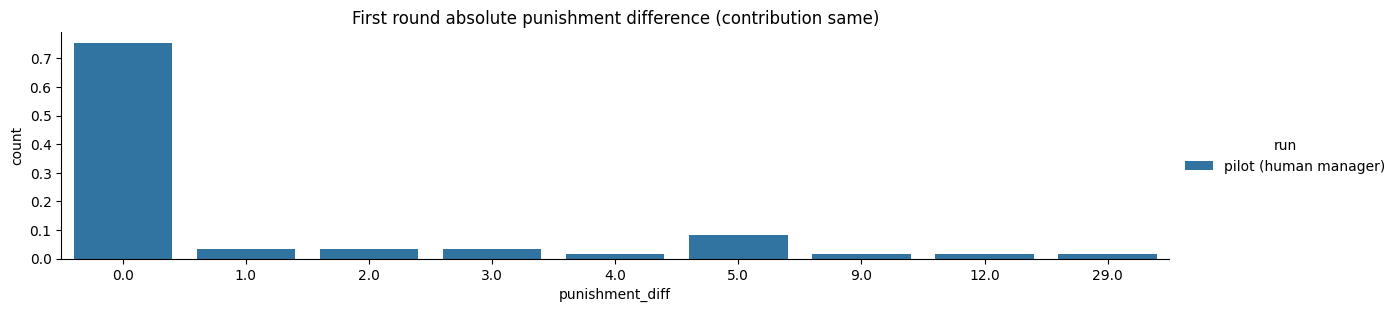

In [38]:
x,y = 'run', 'punishment_diff', 

w = dfm['contribution_same']

y_name = 'count'

((dfm[w]
.groupby(x)[y]
.value_counts(normalize=True)
.rename(y_name))
.reset_index()
.pipe((sns.catplot,'data'), x=y, y=y_name, hue=x,kind='bar', height=3, aspect=4))

plt.title('First round absolute punishment difference (contribution same)')
plt.savefig(os.path.join(plot_folder, 'first_round_punishment_difference.jpg'))
plt.show()


In [39]:
dfm = df.melt(
    id_vars=['episode', 'round_number', 'participant_code', 'run'], 
    value_vars=['punishment', 'contribution', 'common_good'])

# w = ((dfm['round_number'] == 0) & (dfm['variable'] == 'contribution'))

dfs = dfm.groupby(['run', 'round_number', 'variable'])['value'].mean().reset_index()

dfs = dfs.sort_values(['variable','round_number', 'run'])

dfs.to_csv(os.path.join(plot_folder, 'aggregates.csv'), index=False)